In [1]:
import silq
silq.initialize("Serwan")

Initializing imports


<IPython.core.display.Javascript object>

In [1]:
# Imports
import os
import sys
import numpy as np
from functools import partial
from importlib import reload
from time import sleep, time
from matplotlib import pyplot as plt
%matplotlib nbagg

# SilQ imports
import silq
from silq.analysis import analysis
from silq.parameters import measurement_parameters, general_parameters


# Qcodes imports
import qcodes as qc
from qcodes import Instrument
from qcodes.instrument.parameter import Parameter, ManualParameter, StandardParameter
from qcodes.data import hdf5_format
from qcodes.data.data_set import DataSet
h5fmt = hdf5_format.HDF5Format()

from qcodes.data.manager import DataManager, DataServer
from qcodes.data.data_set import new_data, DataMode
from qcodes.data.data_array import DataArray

qc.show_subprocess_widget()

# Data handling
qc.data.data_set.DataSet.default_io.base_location = 'E:\EWJN\data'
loc_provider = qc.data.location.FormatLocation(fmt='{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

In [2]:
# General functions
def plot_traces(traces, traces_AWG=None, threshold_voltage=None):
    plt.figure()
    plt.pcolormesh(range(traces.shape[1]), 
                 range(traces.shape[0]+1), traces)
    if traces_AWG is not None:
        trace_AWG = traces_AWG[:1]
        trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
        trace_AWG -= np.min(trace_AWG)
        plt.pcolormesh(range(traces.shape[1]), 
                       np.array([0,1])+traces.shape[0], trace_AWG)
    plt.xlim([0,traces.shape[1]])
    plt.ylim([0,traces.shape[0]+1])
    plt.gca().invert_yaxis()
    plt.colorbar()

    fig, axes = plt.subplots(len(traces), sharex=True)
    for k, trace in enumerate(traces):
        axes[k].plot(trace)
#         axes[k].plot(trace > 0.5)
        if traces_AWG is not None:
            trace_AWG = traces_AWG[k]
            trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
            trace_AWG -= np.min(trace_AWG)
            axes[k].plot(trace_AWG)
        if threshold_voltage is not None:
            axes[k].plot([threshold_voltage]*len(trace), 'r')
        axes[k].locator_params(nbins=2)

def try_close_instruments(instruments=['pulseblaster', 'arbstudio', 'SIM900', 'ATS', 'ATS_controller', 'pulsemaster'], 
                          reload=False):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument_name in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        try:
            eval('reload({}_driver)'.format(instrument_name))
        except:
            pass
        
def print_voltages(SIM900):
    for channel, name in SIM900.channels().items():
        print('{}({})'.format(name, SIM900.parameters[name]()))

In [3]:
# Load instruments
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as arbstudio_driver
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as pulseblaster_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver
from silq.meta_instruments.pulsemaster import PulseMaster as pulsemaster_driver

try_close_instruments()

dll_path = os.path.join(os.getcwd(),'C:\Lecroy_driver\\Library\\ArbStudioSDK.dll')
arbstudio = arbstudio_driver.ArbStudio1104('ArbStudio', dll_path)

pulseblaster = pulseblaster_driver.PulseBlaster('PulseBlaster', api_path='spinapi.py')

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Basic_AcquisitionController(name='ATS_controller', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

pulsemaster=pulsemaster_driver.PulseMaster(pulseblaster=pulseblaster, 
                                           arbstudio=arbstudio, 
                                           ATS=ATS, 
                                           ATS_controller=ATS_controller, 
                                           server_name='PulseMaster_server')

# Additional parameters
DC_parameter = measurement_parameters.DC_Parameter(pulsemaster=pulsemaster)


In [5]:
data = qc.load_data(r'2016-09-13\#010_T1_data_13-46-56\tau_10000\#001_tau_10000', formatter=h5fmt)

In [10]:
data = qc.load_data(r'2016-09-13\#010_T1_data_13-46-56\tau_6952\#001_tau_6952', formatter=h5fmt)

<IPython.core.display.Javascript object>


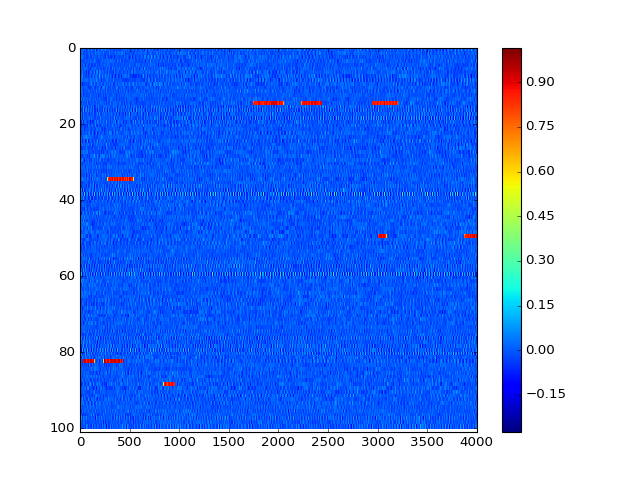

<IPython.core.display.Javascript object>


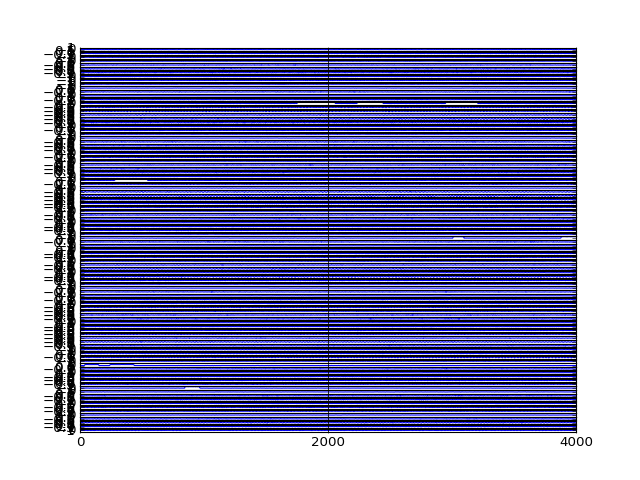

In [11]:
plot_traces(data.data_vals[:100])